## Heat Demand Model - Behaviour Exploration

### Settings

In [1]:
#Load Packages
import numpy as np # linear algebra
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import re 
import itertools
import math
import random
import matplotlib.pyplot as plt
import matplotlib

from IPython.display import display_html
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import *
from scipy import stats
from scipy.stats import gaussian_kde

# for inline plots
%matplotlib inline

mpl.rcParams['figure.figsize'] = (10, 6)
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.labelsize"] = 12
mpl.rc('xtick', labelsize = 12) 
mpl.rc('ytick', labelsize = 12)
sns.set(style = 'whitegrid', palette = 'muted', font_scale = 1)

Helper functions

In [2]:
#sets up Seaborn parametes for plotting
def snsParams(font, color_scheme):
    #seaborn.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)
    sns.set(style = 'whitegrid', palette = color_scheme, font_scale = font)

#makes heat map of correllations
def PlotCorr(X):
    corr = X.corr()
    #fig , ax = plt.figure( figsize = (6,6 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    sns.heatmap(
        corr, cmap = cmap, square = True, cbar = False, cbar_kws = { 'shrink' : 1 }, 
     annot = True, annot_kws = { 'fontsize' : 12 }
    )
    plt.yticks(rotation = 0)
    plt.xticks(rotation = 90) 

Load data

In [3]:
# Get data from csv
data = pd.read_csv("../santboi/data/1906SB_collection_heatd.csv")

# Determine size of data
n_rows, n_cols = data.shape

# Divide data into X and Y data
data_X = pd.DataFrame(data.iloc[:,:-1])
data_y = pd.DataFrame(data.iloc[:,-1:n_cols])

## Data exploration

In [4]:
# print a summary of loaded results
print('FULL DATA')
print('Data has %.0f columns'%(n_cols))
print('Number of rows: %.0f'%(n_rows))

cnt = 0
# print out the features
print('\n\nFeatures: ')
for feature in data_X.columns:
    cnt += 1
    print('%d. '%(cnt), feature,'\t\t')

FULL DATA
Data has 18 columns
Number of rows: 814


Features: 
1.  District 		
2.  Decade 		
3.  Main Orientation 		
4.  Dwellings 		
5.  GF Usage 		
6.  Roof Type 		
7.  Opening Type 		
8.  Party Wall Type 		
9.  Facade Type 		
10.  Courtyards 		
11.  Heights 		
12.  Roof Surface 		
13.  Facade Surface 		
14.  Opening Surface 		
15.  Party Wall Surface 		
16.  Surface ICW Terrain 		
17.  Courtyard Surface 		


For more detail on variable description click [here](https://github.com/carlosdavila91/santboi_eda).

In [5]:
# Print the data to see how it looks like
data.head()

,District,Decade,Main Orientation,Dwellings,GF Usage,Roof Type,Opening Type,Party Wall Type,Facade Type,Courtyards,Heights,Roof Surface,Facade Surface,Opening Surface,Party Wall Surface,Surface ICW Terrain,Courtyard Surface,Heat Demand
0,Marianao,From 1971 to 1980,E,From 5 to 9 dwellings,Commercial,C2,H4,M2,F3,1 courtyard,5,165.43,208.50,56.1150,150.9,150.00,243.5625,44.251546
1,Marianao,From 1971 to 1980,W,From 10 to 19 dwellings,Commercial,C2,H3,M2,F3,2 or more \ncourtyards,5,417.41,547.35,218.9400,36.6,420.00,545.6250,38.328312
2,Marianao,From 1971 to 1980,E,From 10 to 19 dwellings,Commercial,C2,H3,M2,F3,2 or more \ncourtyards,5,202.00,282.00,112.8000,108.9,202.07,603.7500,58.794629
3,Vinyets,From 1941 to 1960,NW,From 2 to 4 dwellings,Dwelling,C1,H3,0,F1,No courtyard,3,96.00,148.80,38.4024,0.0,96.00,0.0000,126.321738
4,Vinyets,From 1941 to 1960,NE,From 2 to 4 dwellings,Dwelling,C1,H4,0,F1,1 courtyard,2,45.00,61.38,18.4170,0.0,80.00,43.8750,69.562085


In [6]:
# provide information about the types of data we are dealing with
print('ORIGINAL DATA:')
data.info()

cnt = 0
d_type = ['float64', 'int64','object','dtype']
for c1 in zip(data.get_dtype_counts()):
    cnt += 1

ORIGINAL DATA:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814 entries, 0 to 813
Data columns (total 18 columns):
District               814 non-null object
Decade                 814 non-null object
Main Orientation       814 non-null object
Dwellings              814 non-null object
GF Usage               814 non-null object
Roof Type              814 non-null object
Opening Type           814 non-null object
Party Wall Type        814 non-null object
Facade Type            814 non-null object
Courtyards             814 non-null object
Heights                814 non-null int64
Roof Surface           814 non-null float64
Facade Surface         814 non-null float64
Opening Surface        814 non-null float64
Party Wall Surface     814 non-null float64
Surface ICW Terrain    814 non-null float64
Courtyard Surface      814 non-null float64
Heat Demand            814 non-null float64
dtypes: float64(7), int64(1), object(10)
memory usage: 114.5+ KB


Incredibly, there is no missing data. (Data was preprocessed before doing this exercise).

In [8]:
# Change object data type to categorical
categorical_features = data.select_dtypes(include=['object','int64']).columns.tolist()

for col in categorical_features:
    data[col] = data[col].astype('category')
    
# Change the order of the categories when they establish a relationship of order 
data['Decade'] = data['Decade'].cat.as_ordered()

data['Dwellings'] = data['Dwellings'].cat.reorder_categories(['Detached', 
                                                              'From 2 to 4 dwellings', 
                                                              'From 5 to 9 dwellings', 
                                                              'From 10 to 19 dwellings',
                                                              'From 20 to 39 dwellings',
                                                              'More than 40 dwellings'], 
                                                             ordered=True)

data['Courtyards'] = data['Courtyards'].cat.reorder_categories(['No courtyard', 
                                                                '1 courtyard',
                                                                '2 or more \ncourtyards'])

data['Heights'] = data['Heights'].cat.as_ordered()

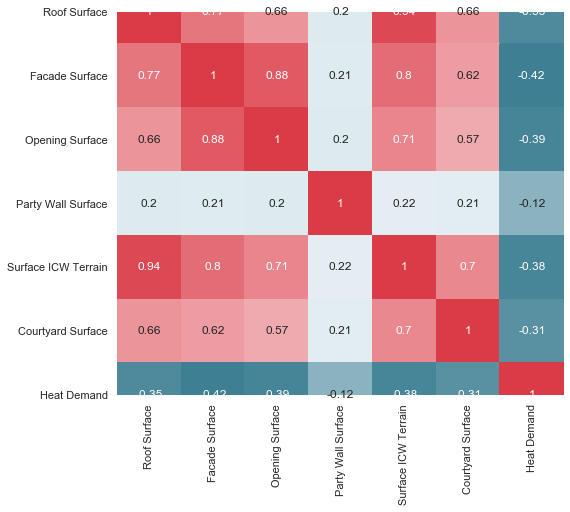

In [9]:
#show the correlations between all the numerical features in a heatmap
plt.figure(figsize = (8,8))
p = PlotCorr(data)

plt.show()

*An issue apears when using seaborn heatmap as indicated in [this post](https://github.com/mwaskom/seaborn/issues/1773). Since the solution is to downgrade the matplotlib version from 3.1.1 to 3.1.0 and this would affect other parts of the code, this plot would remain so untill the new version 3.2.0 of matplotlib is released.*

The correlation between surfaces, as the intuition sugest, are higly correlated (except for the Party Wall Surface which is a variable that contains a great amount of zero values). Meanwhile, the correlations with the heat demand variable is low. The surfaces by themeselves does not mean much.

So, this correlation plot does not give us relevant information. The study must be held giving categorical variables the importance they have.

## Handling outliers

Lets search for outliers in data.

For this study data about buildings was collected manually through tools like google maps, google street view, google earth and the Cadastre of Spain. 

Once the study was completed, it was concluded that this resulted in very inaccurate measurements and difficulties in establishing solid criteria when collecting the data.

Consequently, a great amount of outliers was expected.

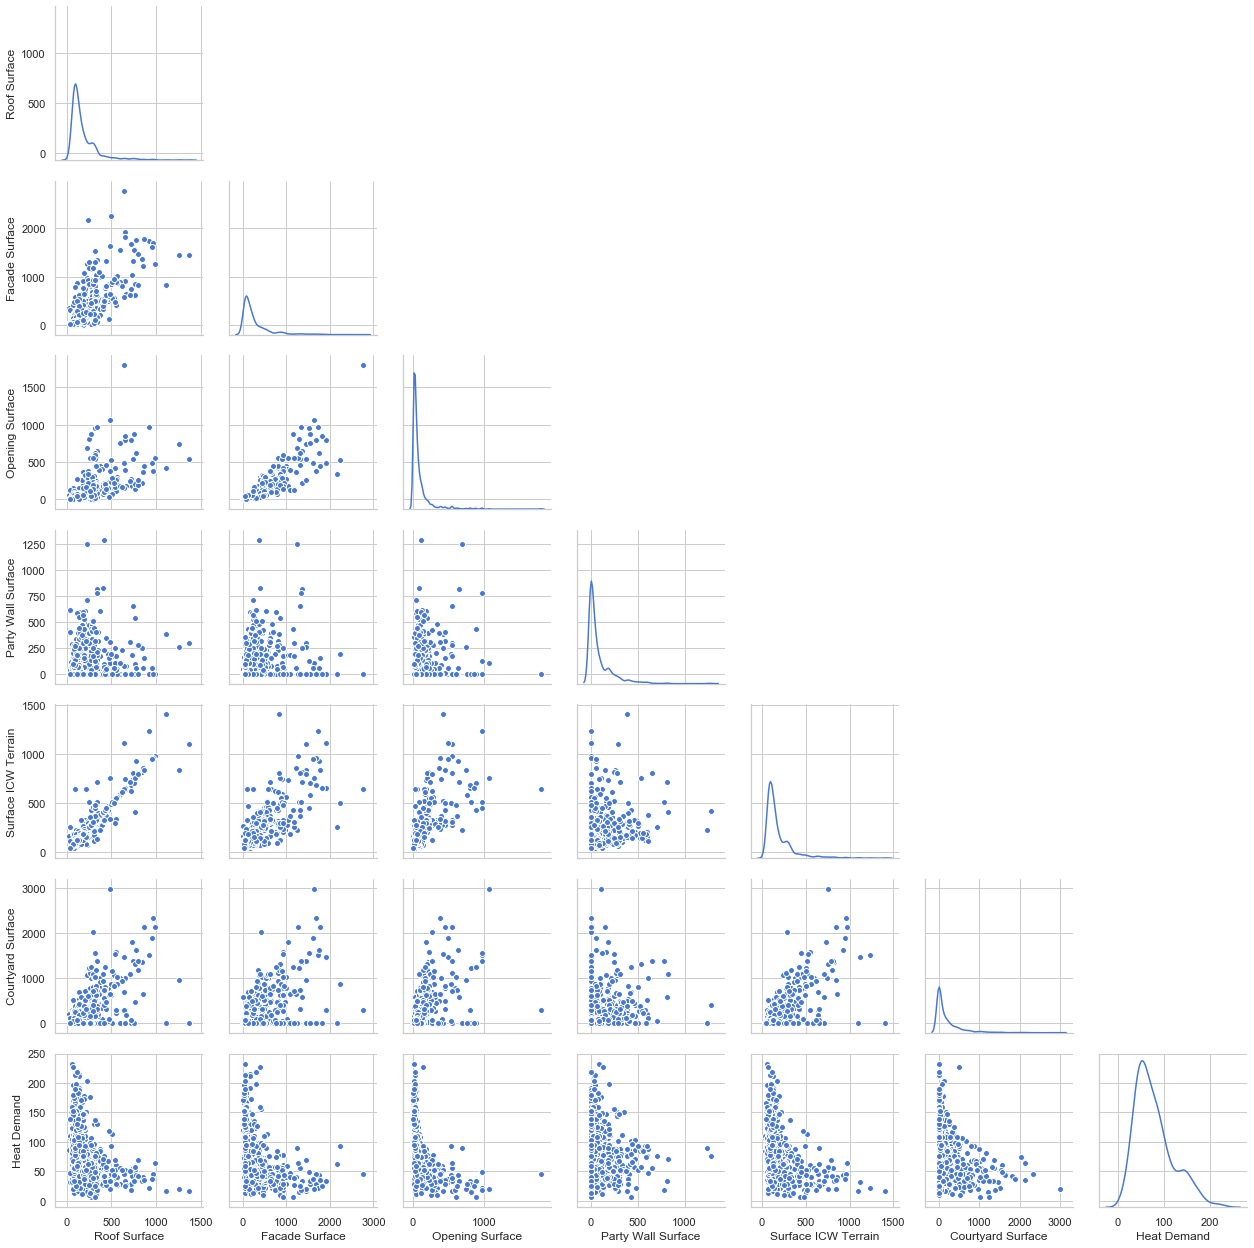

In [10]:
# Print the variable to search for outliers
numerics = ['float64']
num_features = data.select_dtypes(include=numerics).columns.values.tolist()

g = sns.PairGrid(data[num_features])
g.map_diag(sns.kdeplot)
g.map_offdiag(plt.scatter, edgecolor = 'w')

for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

plt.show()

There is, at least one clear outlier. We can detect it easily in the Openings Surface variable with a value superior to 15000.

This huge outlier was erased as the objective of the exercise is to obtain performance ranges of buildings with respect to heating demand, and this type of outlier values can distort the ranges of values we set for this classification.

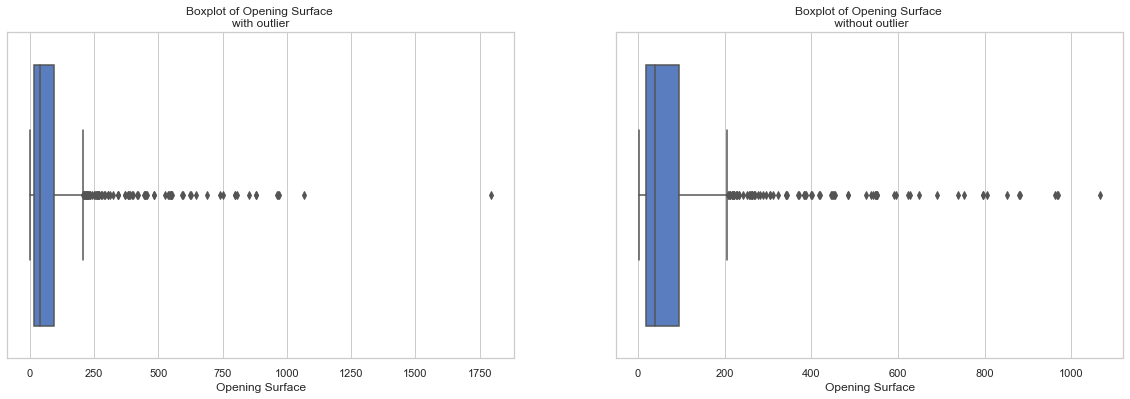

In [11]:
# Filter the data
data_f1 = data[data['Opening Surface'] < 1500]
# Print the boxplot before and after deleting the data point
plt.figure(figsize = (20,6))

plt.subplot(1,2,1)
ax = sns.boxplot(x = "Opening Surface", data = data)
ax.set(title='Boxplot of Opening Surface \nwith outlier', 
       xlabel='Opening Surface')

plt.subplot(1,2,2)
ax = sns.boxplot(x = "Opening Surface", data = data_f1)
ax.set(title ='Boxplot of Opening Surface \n without outlier', 
       xlabel='Opening Surface')

plt.show()

At this point there may be other outliers in data, although detecting them graphicaly may result a little bit confusing. There are various techniques which will help us in this task.

#### Finding Outliers - Z-Score Method

Wikipedia Definition

>The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.

The intuition behind Z-score is to describe any data point by finding their relationship with the Standard Deviation and Mean of the group of data points. Z-score is finding the distribution of data where mean is 0 and standard deviation is 1 i.e. normal distribution.

You must be wondering that, how does this help in identifying the outliers? Well, while calculating the Z-score we re-scale and center the data and look for data points which are too far from zero. These data points which are way too far from zero will be treated as the outliers. In most of the cases a threshold of 3 or -3 is used i.e if the Z-score value is greater than or less than 3 or -3 respectively, that data point will be identified as outliers.

We will use Z-score function defined in scipy library to detect the outliers.

In [12]:
z = np.abs(stats.zscore(data_f1[num_features]))
print(z)

[[0.13637522 0.21350949 0.23774939 ... 0.24463958 0.10374625 0.82972986]
 [1.42393942 0.79631148 0.90615038 ... 1.38190086 0.98033804 0.97227963]
 [0.09007413 0.00553091 0.16048158 ... 0.06904175 1.14901802 0.47973303]
 ...
 [0.0337702  0.48047058 0.22697955 ... 0.05186442 0.60307729 0.07841243]
 [0.67833467 2.67389007 3.23857833 ... 0.71923623 1.46515696 0.94861567]
 [0.4548409  0.65534528 0.34365628 ... 0.39524518 0.4407092  0.462049  ]]


In [13]:
# It returns a list of two arrays: the indexes and the z-score for those data points
threshold = 3
np.where(z > threshold)

(array([  7,   8,  27,  27,  27,  27,  31,  31,  43,  43,  43,  43,  44,
         61,  94, 111, 120, 144, 157, 186, 186, 186, 188, 188, 188, 192,
        192, 192, 192, 193, 193, 195, 195, 196, 196, 196, 197, 197, 198,
        199, 199, 199, 199, 201, 201, 201, 201, 201, 202, 202, 202, 202,
        203, 207, 207, 208, 221, 221, 221, 221, 222, 230, 234, 251, 276,
        281, 281, 281, 281, 281, 283, 283, 297, 308, 308, 308, 308, 308,
        308, 322, 325, 358, 358, 358, 358, 403, 412, 470, 470, 479, 479,
        483, 483, 483, 483, 499, 499, 526, 567, 590, 657, 657, 658, 658,
        658, 658, 665, 667, 685, 700, 710, 710, 710, 710, 713, 713, 713,
        713, 725, 727, 727, 727, 727, 736, 764, 766, 783, 783, 783, 795,
        795, 795, 795, 800, 806, 806, 807, 811]),
 array([6, 6, 0, 1, 2, 4, 0, 4, 0, 1, 2, 4, 2, 3, 3, 3, 6, 3, 5, 0, 4, 5,
        1, 4, 5, 0, 1, 4, 5, 1, 2, 2, 3, 0, 1, 2, 1, 2, 2, 0, 1, 2, 4, 0,
        1, 2, 4, 5, 1, 2, 4, 5, 2, 1, 2, 2, 1, 2, 3, 4, 5, 2, 4, 0, 5, 0

Now, we delete those points from the data set and repeat the procedure to see all numerical variables plotted.

In [14]:
data_f2 = data_f1[(z < 3).all(axis=1)]

#### Finding Outliers - IQR Method

The first one is the IQR method, where every data point above or below 1.5 times the IQR is an outlier.

Wikipedia definition

> The **interquartile range** (**IQR**), also called the **midspread** or **middle 50%**, or technically **H-spread**, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1".

> In other words, the IQR is the first quartile subtracted from the third quartile; these quartiles can be clearly seen on a box plot on the data.

> It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers.

In [15]:
# Calculate the IQR
Q1 = data_f1[num_features].quantile(0.25)
Q3 = data_f1[num_features].quantile(0.75)
IQR = Q3 - Q1

# Lets filter out the outliers by keeping only valid values
data_f3 = data_f1[~((data_f1[num_features] < (Q1 - 1.5 * IQR)) | 
                    (data_f1[num_features] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [16]:
data.shape[0], data_f1.shape[0], data_f2.shape[0], data_f3.shape[0]

(814, 813, 746, 619)

The obtained results show how the Z-score method is less restrictive (763 data points remain) than the IQR-score one (681 data points remain).

Despite difficulties in collecting data and possible inaccuracy, the method selected was z-score. After all, the buildings in both districts are heterogeneous and part of this variety must be taken into account for the study while we try to avoid the dragged error. So, we mantain the `data_f2` data frame for the following study.

In [17]:
data_clean = data_f2

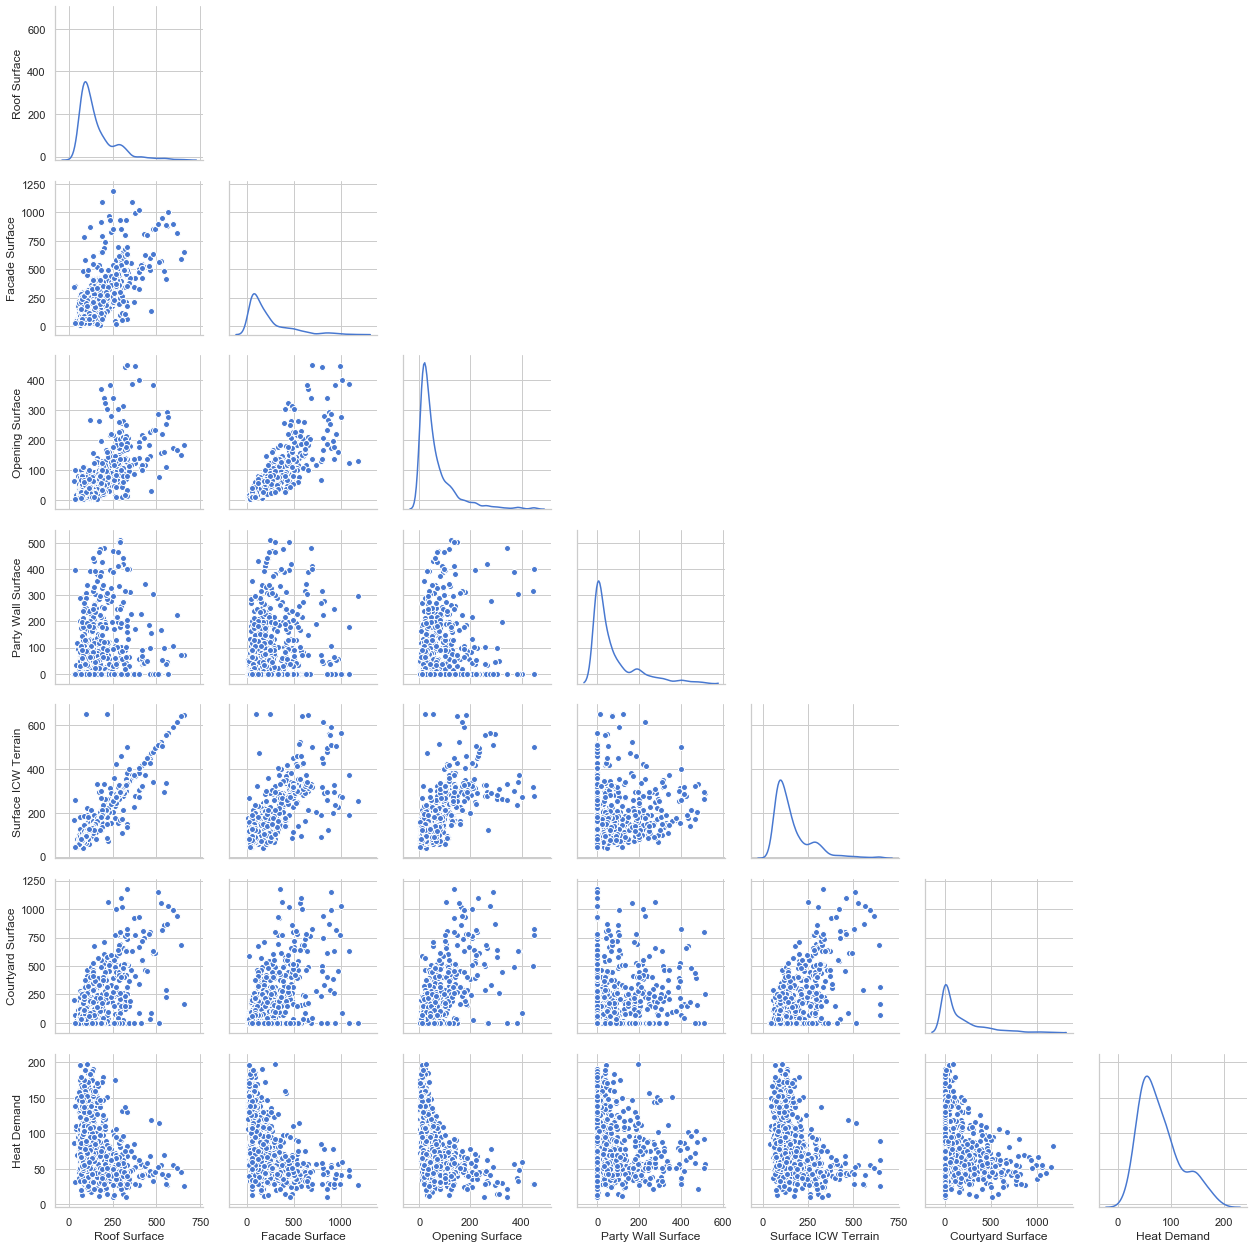

In [18]:
# Rewrite numerical data to multivariate plot
g = sns.PairGrid(data_clean[num_features])
g.map_diag(sns.kdeplot)
g.map_offdiag(plt.scatter, edgecolor = 'w')

# Hide the plots over the diagonal to avoid redundancies
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

plt.show()

There are still a few data points that should be consider outliers. These are those whose relationship between Roof Surface and Surface in Contact With Terrain are clearly unbalanced, something that souldn't be happening. Those data points were deleted from the data frame.

In [19]:
data_clean = data_clean[~((data_clean['Roof Surface']<250)&
                        (data_clean['Surface ICW Terrain']>600))]

### Transform Heat Demand into categories

Now we use the function `pd.cut` to set the categories for the `Heat Demand` variable. Notice that, as a simplification, three categories has been defined for Heat Demand, corresponding the numbers to the next categories:

* Low = 0
* Middle = 1
* High = 2

In [20]:
data['Heat Demand'].mean(), data['Heat Demand'].median()

(78.68675889318067, 69.39149511)

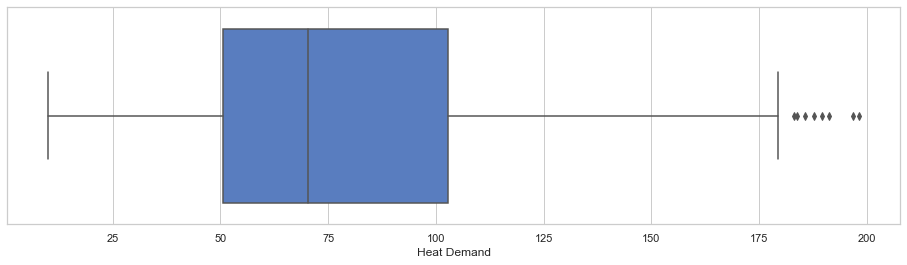

In [21]:
plt.figure(figsize = (16,4))
sns.boxplot(x = "Heat Demand", data = data_clean)
plt.show()

In [22]:
np.max(data_clean['Heat Demand'])

198.2716028

In [23]:
bins = [-np.inf,50,100,np.inf]

#use pd.cut function can attribute the values into its specific bins
category = pd.cut(data_clean['Heat Demand'],bins, labels = [0, 1, 2])
category = category.to_frame()
category.columns = ['Heat Demand Range']
#concatenate age and its bin
data_clean = pd.concat([data_clean,category],axis = 1)
# df_out['Heat Demand Range'] = str(df_out['Heat Demand Range'])
data_clean.iloc[:,-2:].head()

,Heat Demand,Heat Demand Range
0,44.251546,0
1,38.328312,0
2,58.794629,1
3,126.321738,2
4,69.562085,1


### Heat Demand by District

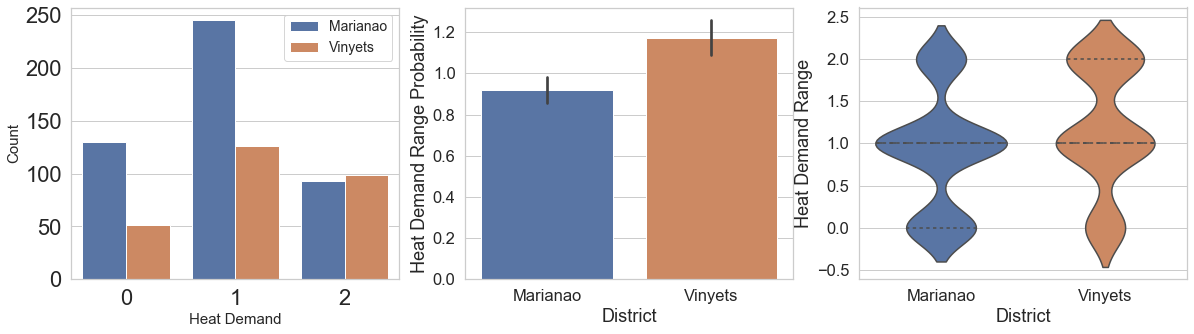

In [24]:
snsParams(2, 'deep')
# plot survival count for male and female
plt.figure(figsize = (20,5))
plt.subplot(1, 3, 1)
b = sns.countplot(x = 'Heat Demand Range',hue = 'District', data = data_clean);
b.set_xlabel("Heat Demand",fontsize = 15)
b.set_ylabel("Count",fontsize = 15)
b.legend(fontsize = 14)
snsParams(1.5, 'deep')

#heat demand probability for Marianao and Vinyets
plt.subplot(1, 3, 2)
sns.barplot(x = "District", y = "Heat Demand Range",orient = 'v', data = data_clean)
plt.ylabel("Heat Demand Range Probability")

plt.subplot(1, 3, 3)
sns.violinplot(y = 'Heat Demand Range', x = 'District', orient = 'v', 
              data = data_clean, inner = 'quartile')
plt.show()

The first count plot shows the count of buildings for each category of Heat Demand. It actually shows de distribution of each district in relation to these categories. It also shows that in Marianao are ~125 buildings with low range of Heat Demand, 250 have middle range and ~95 has high range of Heat Demand. Meanwhile, in Vinyets, where less data points are counted, there are ~50 buildings with low range, ~130 with middle range and ~99 with a high Heat Demand range.

The second plot indicates a tendency of the Heat Demand range in Marianao to be 1 or less, while in Vinyets the most comon values are 1 or bigger than 1.

This same idea is reinforced in the violin plot, the third one. We can see that in Marianao the Heat Demand Range is more likely to be 0 or 1 (Low or middle), while in Vinyets values 1 and 2 (middle or high) are more frecuent.

From this it seems that it tends to present higher heat demand values in Vinyets.

### Decade

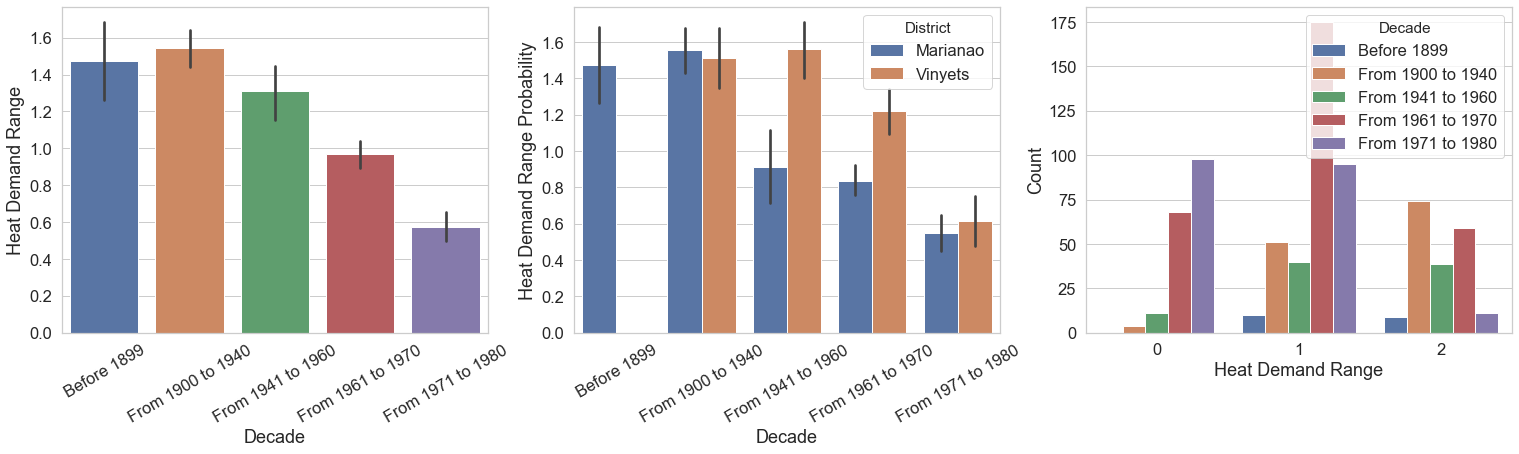

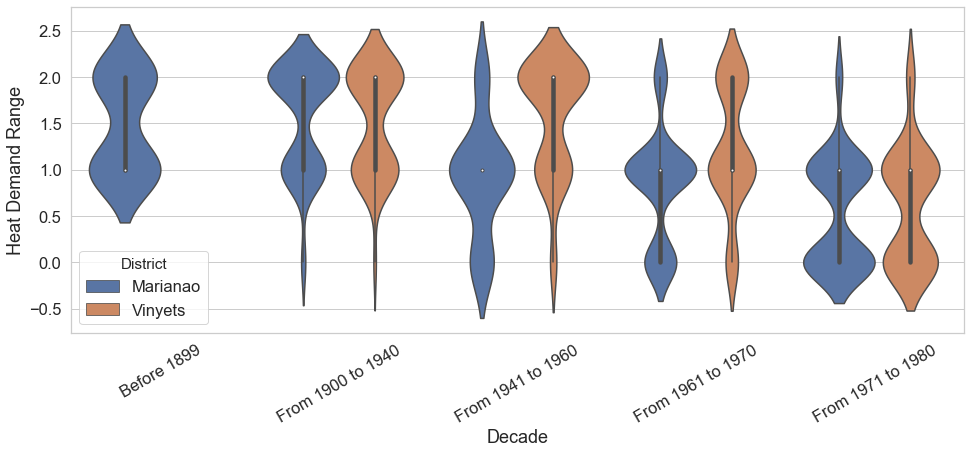

In [25]:
plt.figure(figsize = (26,6))
plt.subplot(1, 3, 1)
sns.barplot(x = 'Decade', y = 'Heat Demand Range', orient = 'v', 
            data = data_clean)
plt.xticks(rotation=30)

# Explore Decade vs Heat Demand Range by District
plt.subplot(1, 3, 2)
sns.barplot(x = "Decade", y = "Heat Demand Range", orient = 'v',
               hue = "District", data = data_clean)
plt.ylabel("Heat Demand Range Probability")
plt.xticks(rotation=30)

plt.subplot(1, 3, 3)
sns.countplot(x = 'Heat Demand Range',hue = 'Decade',data = data_clean)
plt.ylabel('Count')

# Another subplot
plt.figure(figsize = (16,6))
sns.violinplot(y = 'Heat Demand Range', x = 'Decade', orient = 'v',
               hue = 'District', data = data_clean)
plt.xticks(rotation=30)

plt.show()

As we can see, the decade of construction is contributing to the building energy performance. Buildings are more likely to have a major Heat Demand Range the older they are.

### Main Orientation

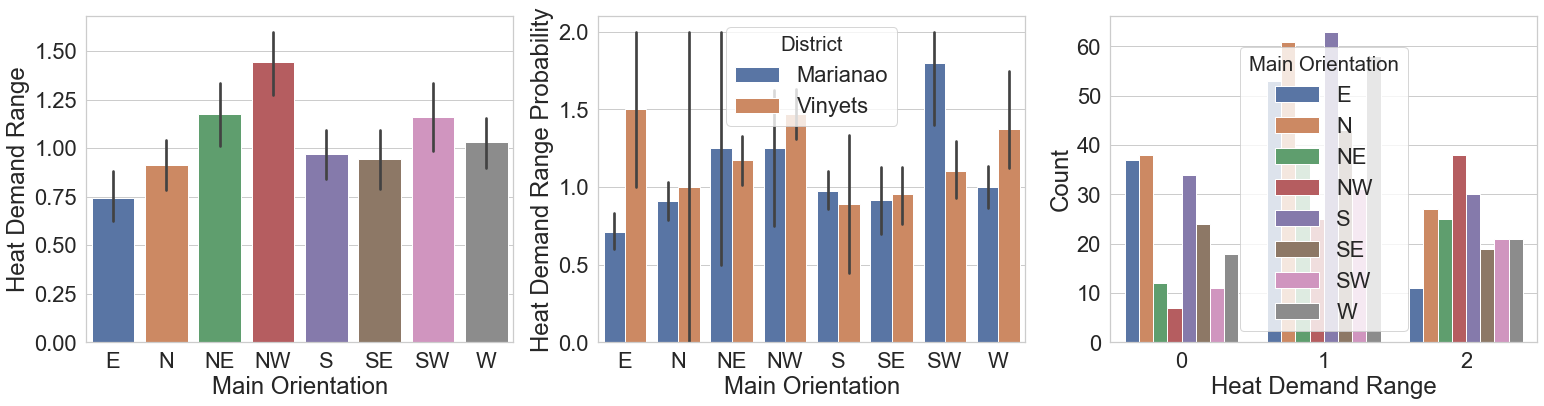

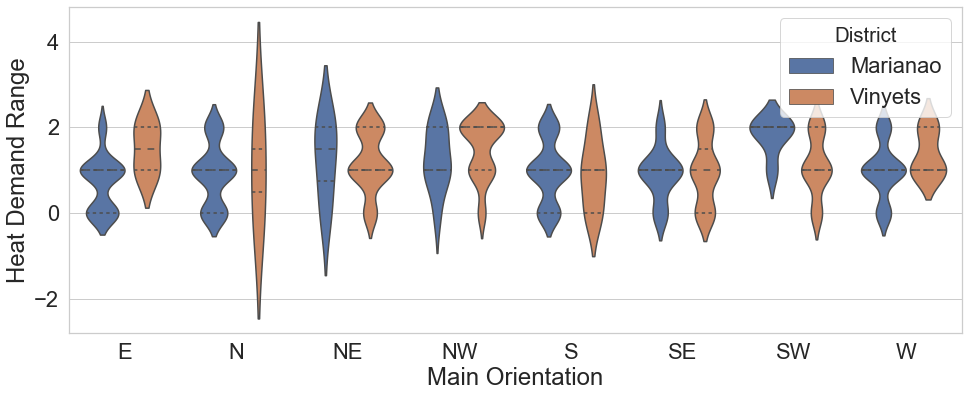

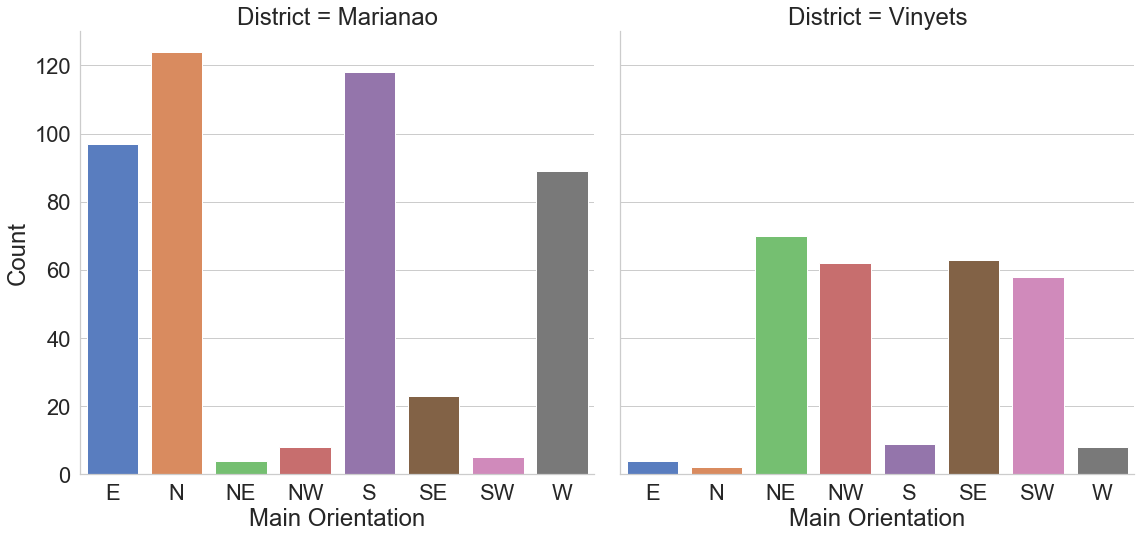

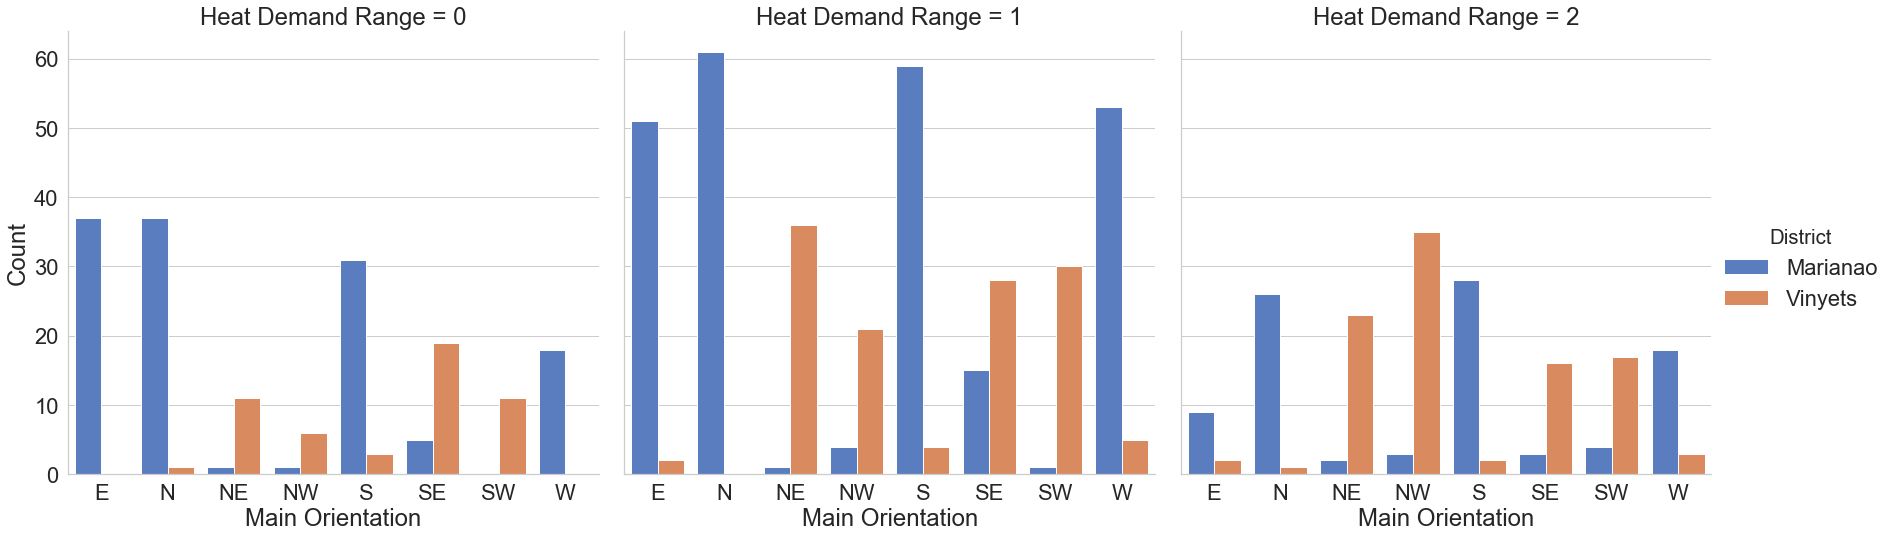

In [92]:
# Explore Main Orientation vs Heat Demand Range by District
plt.figure(figsize = (26,6))
plt.subplot(1, 3, 1)
sns.barplot(x = 'Main Orientation', y = 'Heat Demand Range', orient = 'v', 
            data = data_clean)

plt.subplot(1, 3, 2)
sns.barplot(x = "Main Orientation", y = "Heat Demand Range", orient = 'v',
               hue = "District", data = data_clean)
plt.ylabel("Heat Demand Range Probability")

plt.subplot(1, 3, 3)
sns.countplot(x = 'Heat Demand Range',hue = 'Main Orientation',data = data_clean)
plt.ylabel('Count')

# Another subplot
plt.figure(figsize = (16,6))
sns.violinplot(y = 'Heat Demand Range', x = 'Main Orientation', orient = 'v',
               hue = 'District', data = data_clean, inner = 'quartile')

# Explore Main Orientation vs District 
snsParams(2,'deep')

g = sns.catplot("Main Orientation", col = "District",  data = data_clean, height = 8, 
                   kind = "count", palette = "muted")
g = g.set_ylabels("Count")

g = sns.catplot("Main Orientation", col = "Heat Demand Range",  data = data_clean,
                   hue = 'District',height = 8, kind = "count", palette = "muted")
g = g.set_ylabels("Count")

plt.show()

The orientations of the buildings in the different districts take inverse values. In Marianao we can see that the most prevalent orientations are E, N, S and W; meanwhile in Vinyets NE, NW, SE, and SW are more frequent.

Another fact that stands out is the great variability in the North orientated buildings in Vinyets, which may be observed in the violin plot. This may be indicating errors when gathering the data.

In Heat Demand Ranges 0 and 1 the most frequent orientations are theoretically the most favourable in relation to energy consumption in a temperate climate like this of the Mediterranean (in order S, SE, E, SW, W, N, NE, NW).

In [28]:
data_clean[(data_clean['District']=='Vinyets')&(data_clean['Main Orientation']=='N')]

,District,Decade,Main Orientation,Dwellings,GF Usage,Roof Type,Opening Type,Party Wall Type,Facade Type,Courtyards,Heights,Roof Surface,Facade Surface,Opening Surface,Party Wall Surface,Surface ICW Terrain,Courtyard Surface,Heat Demand,Heat Demand Range
87,Vinyets,From 1961 to 1970,N,From 2 to 4 dwellings,Commercial,C4,H4,M2,F3,No courtyard,5,102.00,244.71,49.333728,52.41,98.00,0.0,39.211980,0
772,Vinyets,From 1961 to 1970,N,Detached,Dwelling,C3,H4,M1,F3,No courtyard,1,86.04,96.33,26.082000,7.44,86.04,0.0,103.273134,2


### Heights

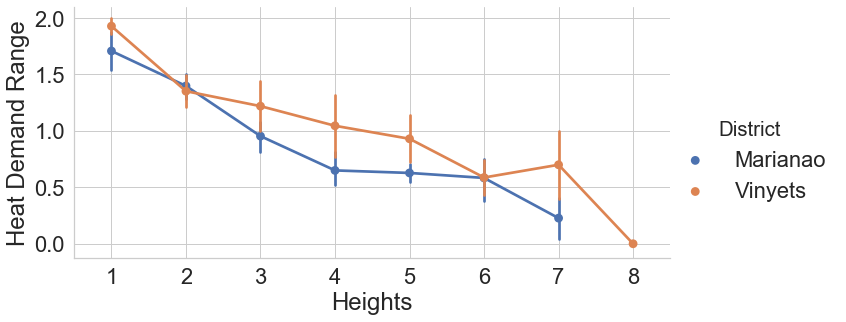

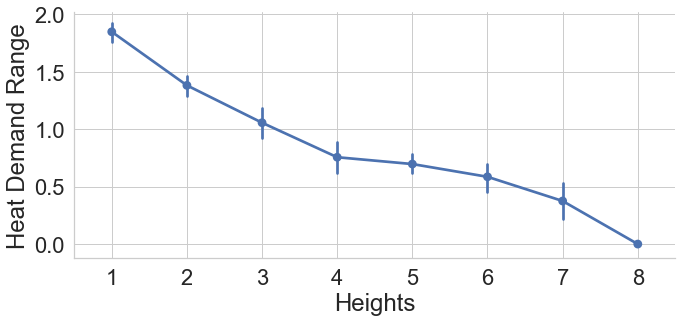

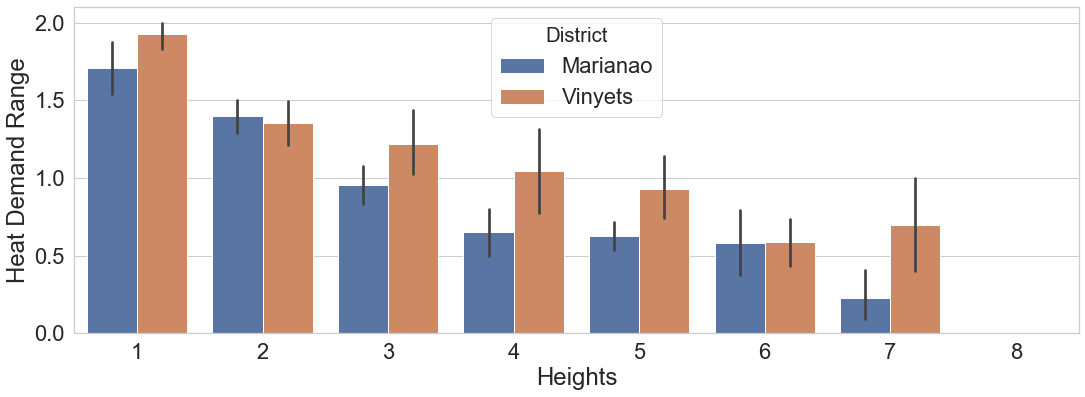

In [29]:
# Explore heights
axes = sns.catplot(x = 'Heights', y = 'Heat Demand Range', orient = 'v',  
                   hue = 'District', kind = 'point', data = data_clean, aspect = 2)
plt.grid(True)
axes = sns.catplot(x = 'Heights',y = 'Heat Demand Range', orient = 'v',
                   data = data_clean, kind = 'point', aspect = 2)
plt.grid(True)

plt.figure(figsize=(18,6))
sns.barplot(x = "Heights", y = "Heat Demand Range", orient = 'v',
            hue = "District", data = data_clean)
plt.show()

In these plots we can observe the most relevant phenomenon in terms of the relationship of a variable with the heating demand. It is made clear that the smaller the number of plants, the more likely it is to be in a range of medium or high demand, which is relevant when developing an intervention strategy in buildings.

In turn, there are no significant differences between neighbourhoods.

### Dwellings

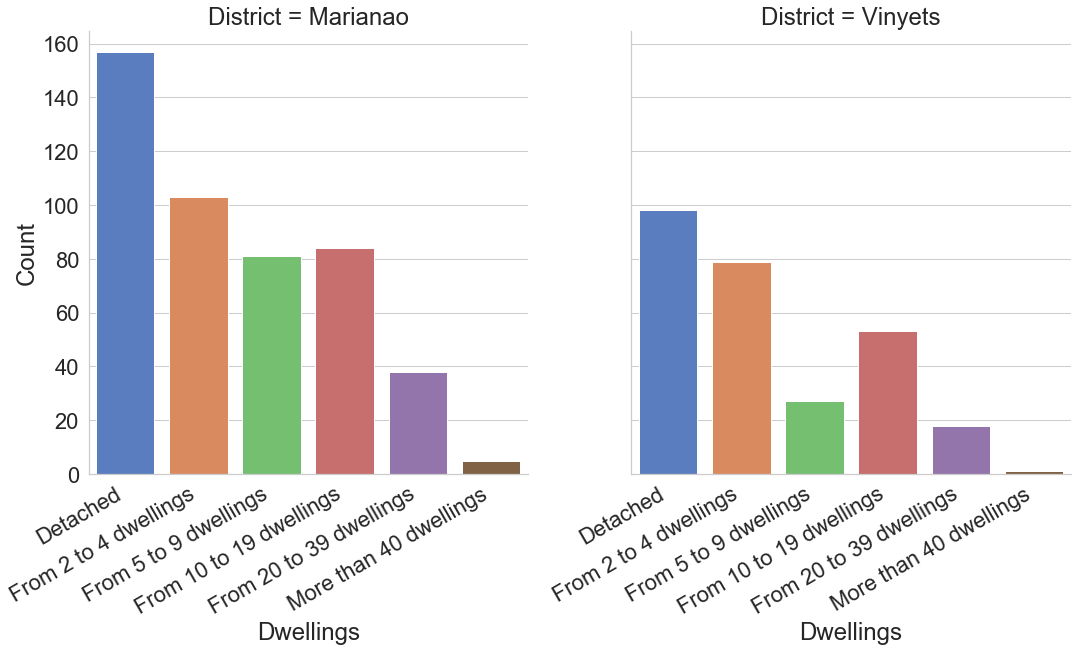

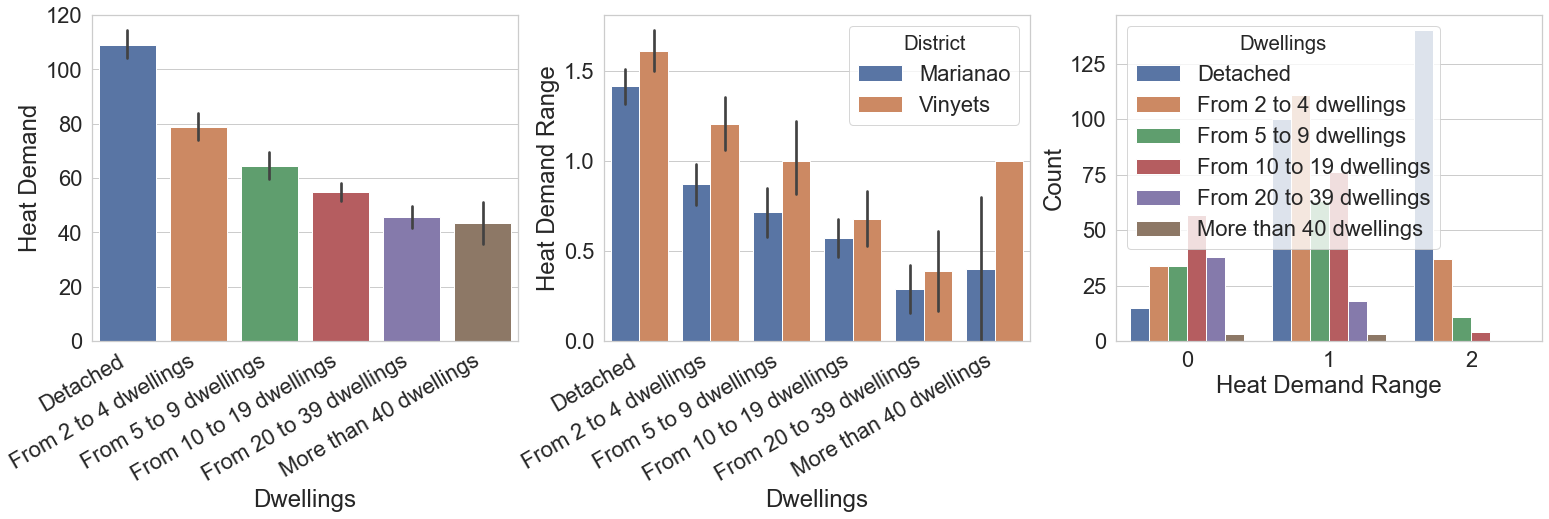

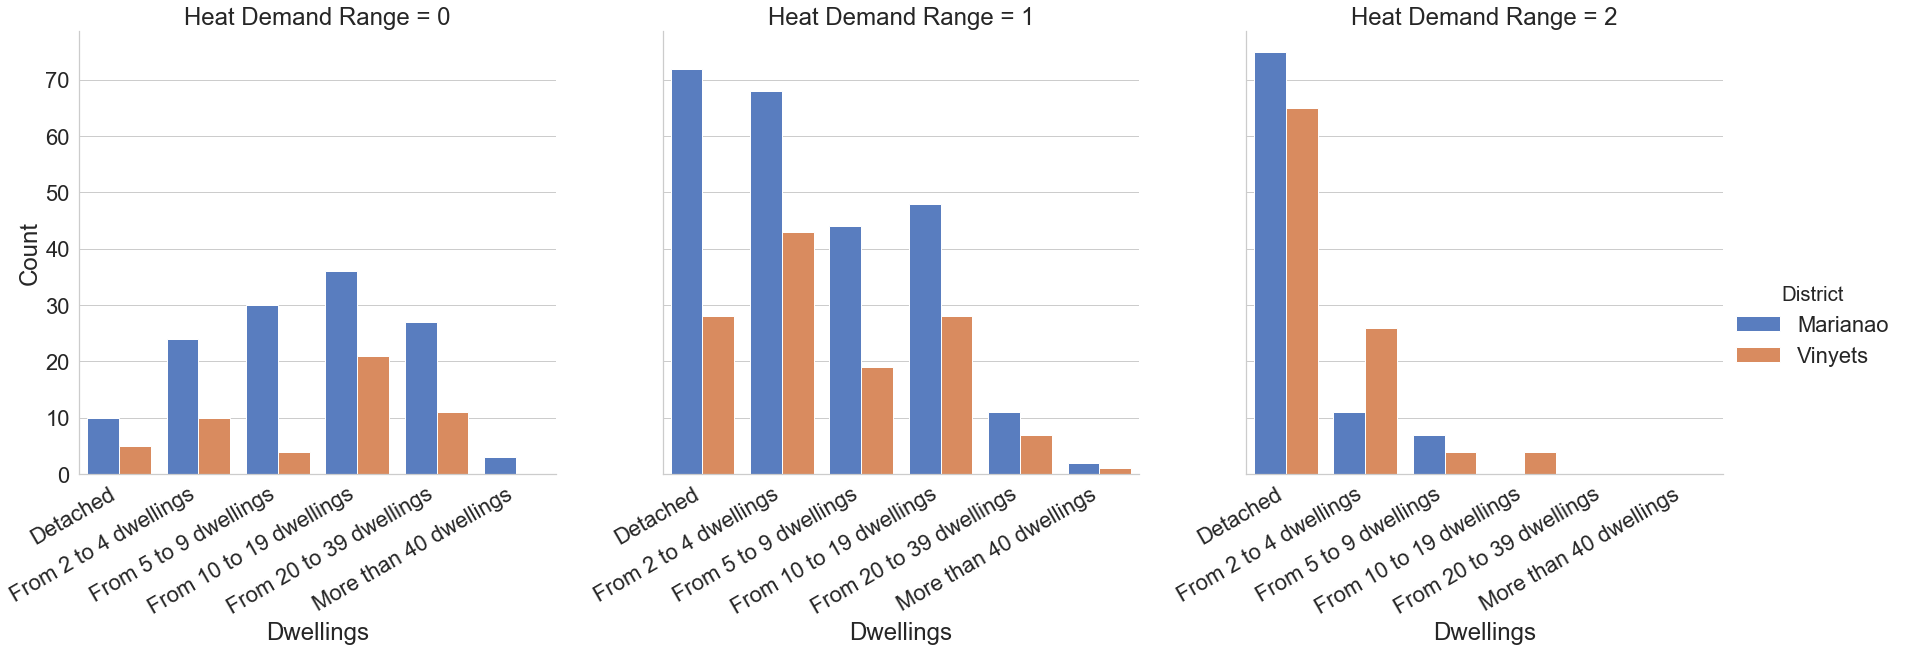

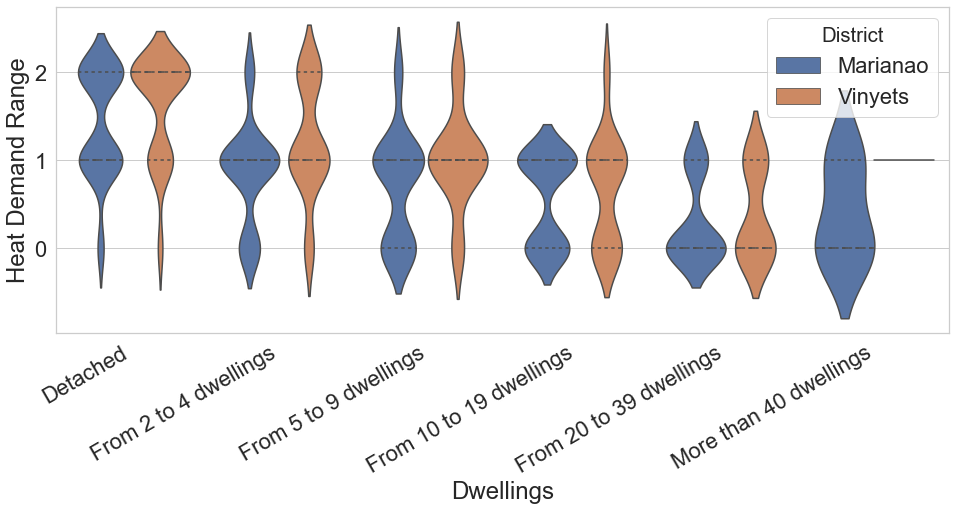

In [82]:
# Explore Dwellings vs District 
g = sns.catplot("Dwellings", col = "District",  data = data_clean, height = 8, 
                   kind = "count", palette = "muted")
g.set_ylabels("Count")
g.set_xticklabels(rotation = 30, ha = 'right')
        
plt.figure(figsize = (26,6))
plt.subplot(1, 3, 1)
sns.barplot(x = 'Dwellings', y = 'Heat Demand', orient = 'v', 
            data = data_clean)
plt.xticks(rotation = 30, ha = 'right')

plt.subplot(1, 3, 2)
sns.barplot(x = "Dwellings", y = "Heat Demand Range", orient = 'v',
               hue = "District", data = data_clean)
plt.ylabel("Heat Demand Range")
plt.xticks(rotation = 30, ha = 'right')

plt.subplot(1, 3, 3)
sns.countplot(x = 'Heat Demand Range',hue = 'Dwellings',data = data_clean)
plt.ylabel('Count')

# Explore Dwellings vs Heat Demand Range by District
g = sns.catplot("Dwellings", col = "Heat Demand Range",  data = data_clean,
                   hue = 'District',height = 8, kind = "count", palette = "muted")
g.set_ylabels("Count")
g.set_xticklabels(rotation = 30, ha = 'right')

# Another subplot
plt.figure(figsize = (16,6))
sns.violinplot(y = 'Heat Demand Range', x = 'Dwellings', orient = 'v',
               hue = 'District', data = data_clean, inner = 'quartile')
plt.xticks(rotation = 30, ha = 'right')

plt.show()

It is noted that the buildings with the lowest number of dwellings are those that accumulate the highest demand, the large buildings are few and add up the least demand.

When defining the scope of an intervention, this variable plays a key role, both because of its relation to the size of the building and its heights, and because of the number of people on whom the intervention is passed.

One possible strategy would be to intervene buildings with the highest number of dwellings that tend to have the highest range of heating demand, for example from 5 to 9 dwellings.

### Ground Floor Usage

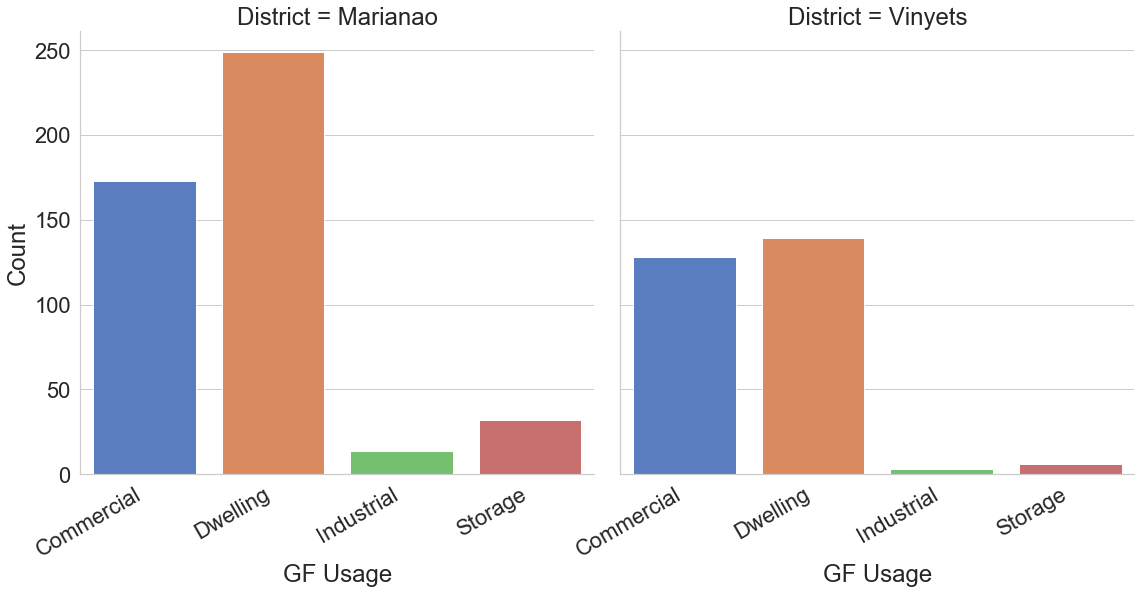

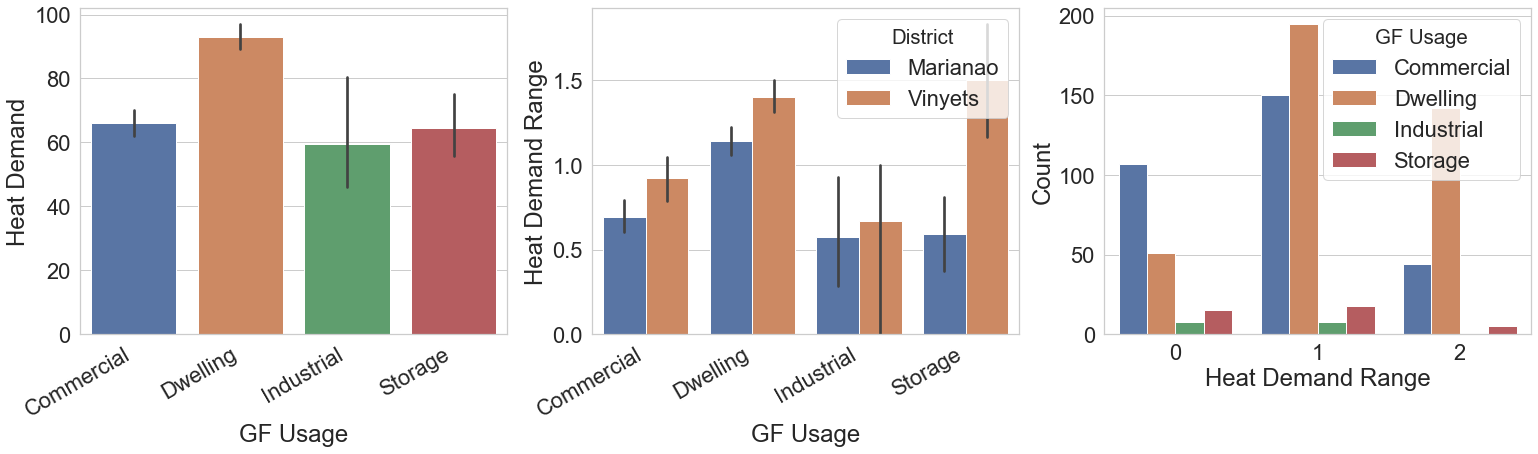

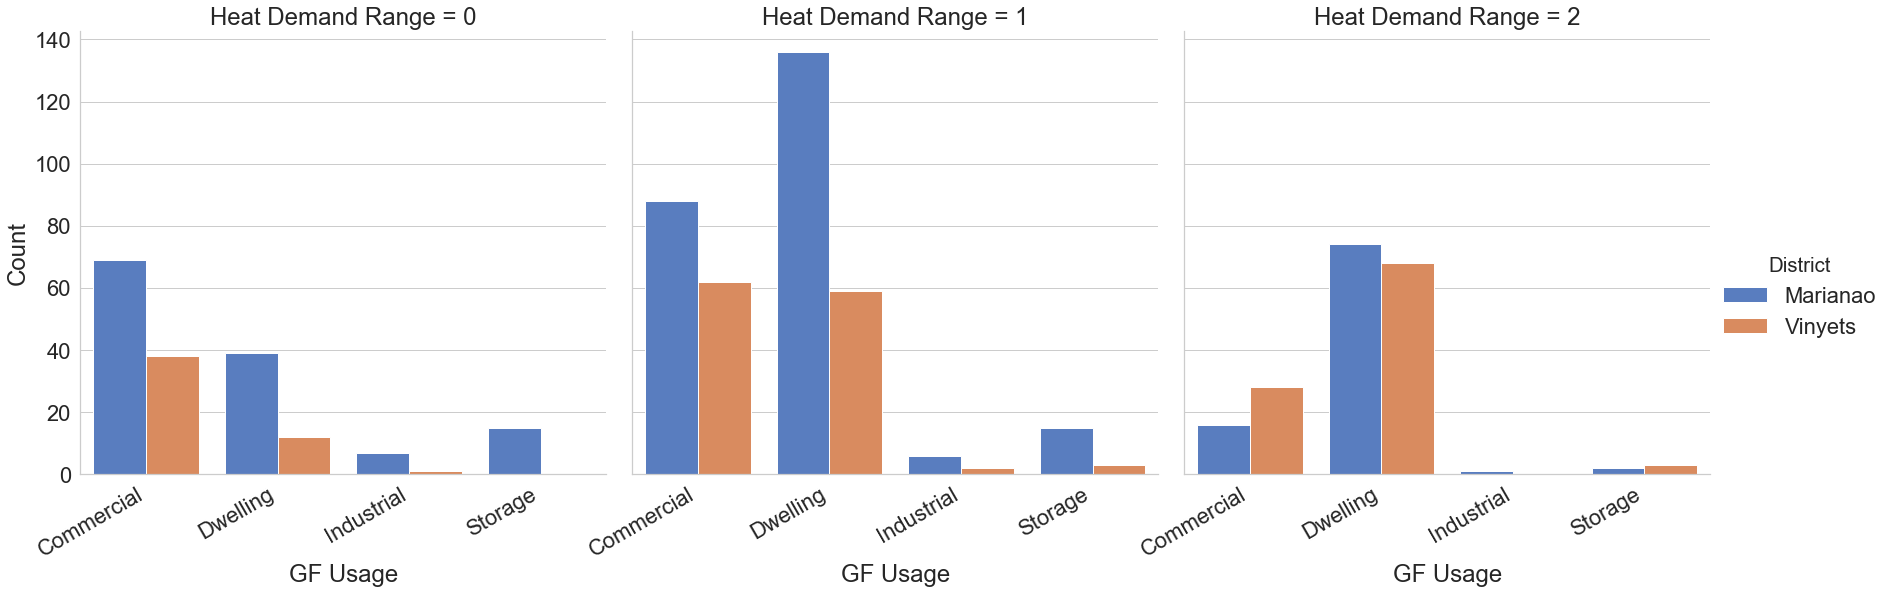

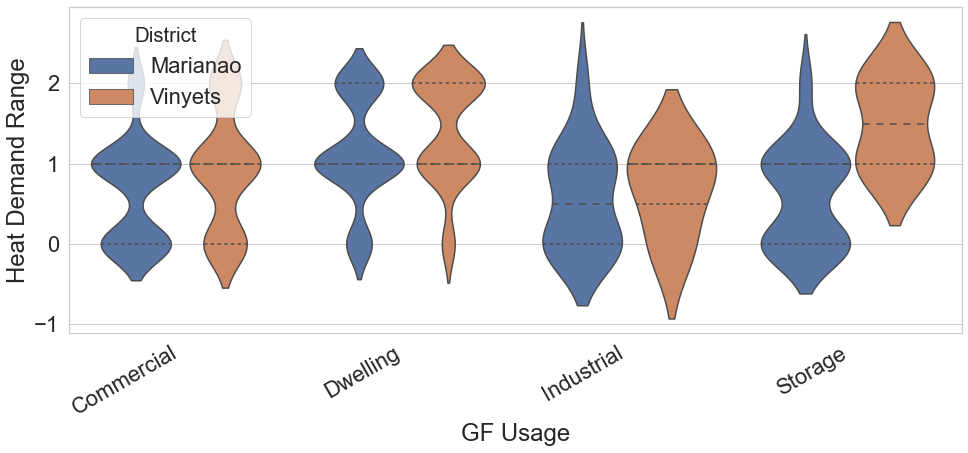

In [86]:
# Explore GF Usage vs District 
g = sns.catplot("GF Usage", col = "District",  data = data_clean, height = 8, aspect = 1,
                   kind = "count", palette = "muted")
g.set_ylabels("Count")
g.set_xticklabels(rotation = 30, ha = 'right')
        
plt.figure(figsize = (26,6))
plt.subplot(1, 3, 1)
sns.barplot(x = 'GF Usage', y = 'Heat Demand', orient = 'v', 
            data = data_clean)
plt.xticks(rotation = 30, ha = 'right')

plt.subplot(1, 3, 2)
sns.barplot(x = "GF Usage", y = "Heat Demand Range", orient = 'v',
               hue = "District", data = data_clean)
plt.ylabel("Heat Demand Range")
plt.xticks(rotation = 30, ha = 'right')

plt.subplot(1, 3, 3)
sns.countplot(x = 'Heat Demand Range',hue = 'GF Usage',data = data_clean)
plt.ylabel('Count')

# Explore GF Usage vs Heat Demand Range by District
g = sns.catplot("GF Usage", col = "Heat Demand Range",  data = data_clean,
                   hue = 'District',height = 8, kind = "count", palette = "muted")
g.set_ylabels("Count")
g.set_xticklabels(rotation = 30, ha = 'right')
        
# Another subplot
plt.figure(figsize = (16,6))
sns.violinplot(y = 'Heat Demand Range', x = 'GF Usage', orient = 'v',
               hue = 'District', data = data_clean, inner = 'quartile')
plt.xticks(rotation = 30, ha = 'right')

plt.show()

Contrary to expectations, having a ground floor use different from that of housing tends to give a lower range of heating demand than if the use is housing.

### Roof Type and Roof Surface

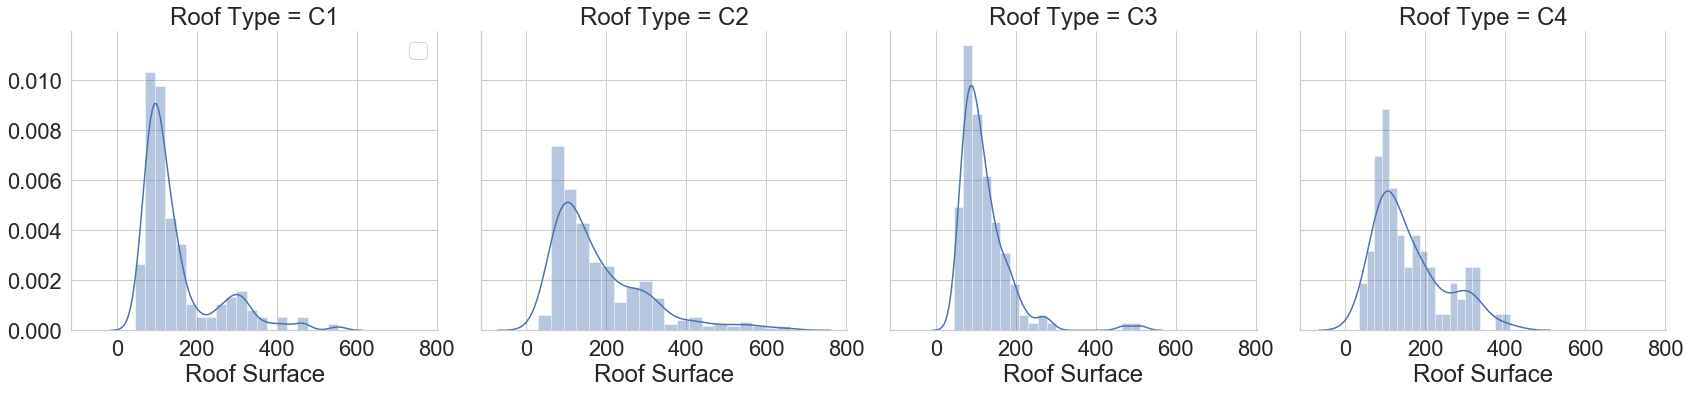

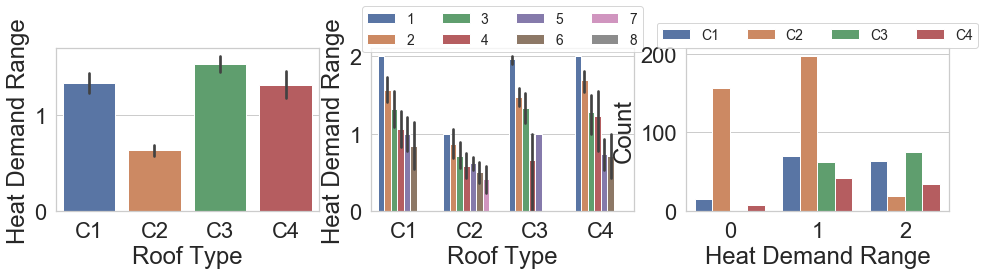

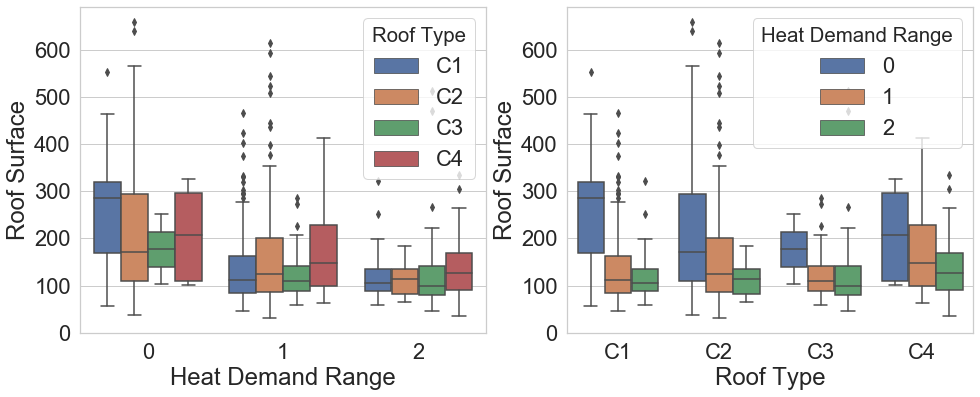

In [91]:
# Plot distributions by category
g=sns.FacetGrid(data_clean, col = 'Roof Type', 
            height = 6, aspect = 1, legend_out=False)
g=g.map(sns.distplot,'Roof Surface', bins = 20, kde=True).add_legend()

# Plot categorical and numerical variables
plt.figure(figsize = (16,3))
plt.subplot(1, 3, 1)
sns.barplot(x = 'Roof Type', y = 'Heat Demand Range', orient = 'v', 
            data = data_clean)

plt.subplot(1, 3, 2)
g = sns.barplot(x = "Roof Type", y = "Heat Demand Range", orient = 'v',
                hue = "Heights", data = data_clean)
plt.legend(loc='upper center', ncol = 4, fontsize = 'xx-small', 
           bbox_to_anchor = (0.5,1.3))

plt.subplot(1, 3, 3)
sns.countplot(x = 'Heat Demand Range',hue = 'Roof Type', orient = 'v',
              data = data_clean)
plt.ylabel("Count")
plt.legend(loc='upper center', ncol = 4, fontsize = 'xx-small', 
           bbox_to_anchor = (0.5,1.2))

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.boxplot(y = "Roof Surface", x = "Heat Demand Range", hue = "Roof Type",
                    data = data_clean)
plt.subplot(1,2,2)
sns.boxplot(y = 'Roof Surface' , x = 'Roof Type', hue = 'Heat Demand Range',
           data = data_clean)
plt.show()

It can be observed that:
* The type of cover C2 is more favorable than the rest
* Great variability in the middle and low heating demand ranges compared to the type of housing

### Facade Type and Facade Surface

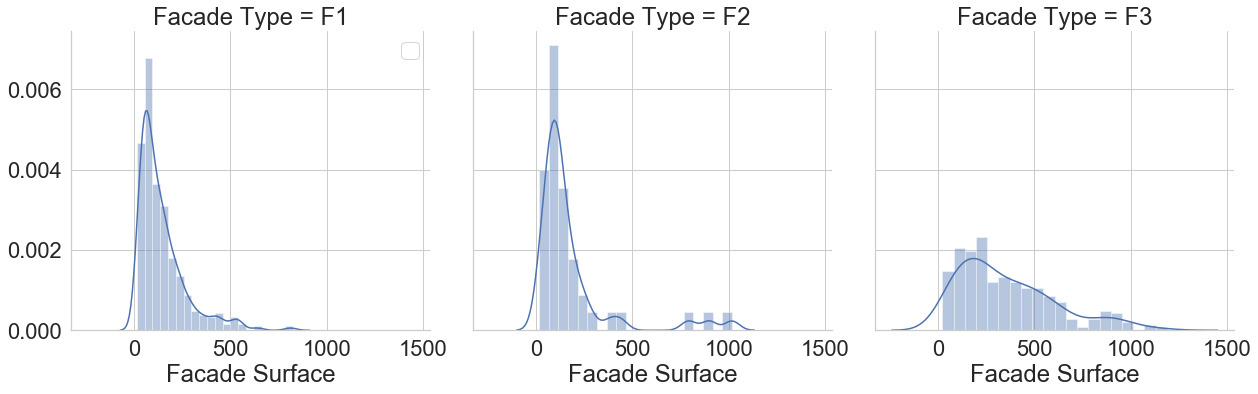

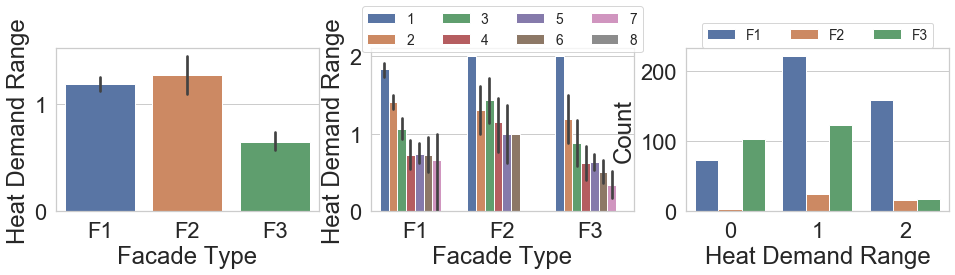

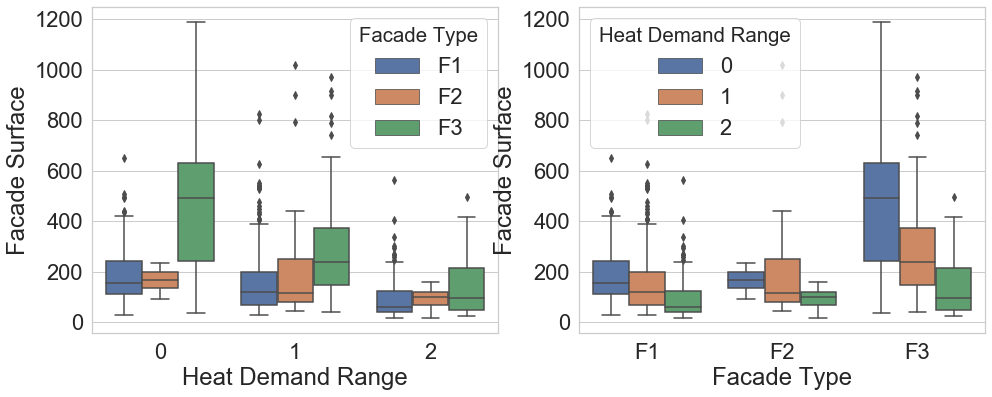

In [89]:
# Plot distributions by category
g=sns.FacetGrid(data_clean, col = 'Facade Type',
            height = 6, aspect = 1, legend_out=False)
g=g.map(sns.distplot,'Facade Surface', bins = 20, kde=True).add_legend()

# Plot categorical and numerical variables
plt.figure(figsize = (16,3))
plt.subplot(1, 3, 1)
sns.barplot(x = 'Facade Type', y = 'Heat Demand Range', orient = 'v', 
            data = data_clean)

plt.subplot(1, 3, 2)
g = sns.barplot(x = "Facade Type", y = "Heat Demand Range", orient = 'v',
                hue = "Heights", data = data_clean)
plt.legend(loc='upper center', ncol = 4, fontsize = 'xx-small', 
           bbox_to_anchor = (0.5,1.3))

plt.subplot(1, 3, 3)
sns.countplot(x = 'Heat Demand Range',hue = 'Facade Type', orient = 'v',
              data = data_clean)
plt.ylabel("Count")
plt.legend(loc='upper center', ncol = 4, fontsize = 'xx-small', 
           bbox_to_anchor = (0.5,1.2))

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.boxplot(y = "Facade Surface", x = "Heat Demand Range", hue = "Facade Type",
                    data = data_clean)
plt.subplot(1,2,2)
sns.boxplot(y = 'Facade Surface' , x = 'Facade Type', hue = 'Heat Demand Range',
           data = data_clean)
plt.show()

The Facade Type F3 is the most favorable, as expected.

### Opening Type and Opening Surface

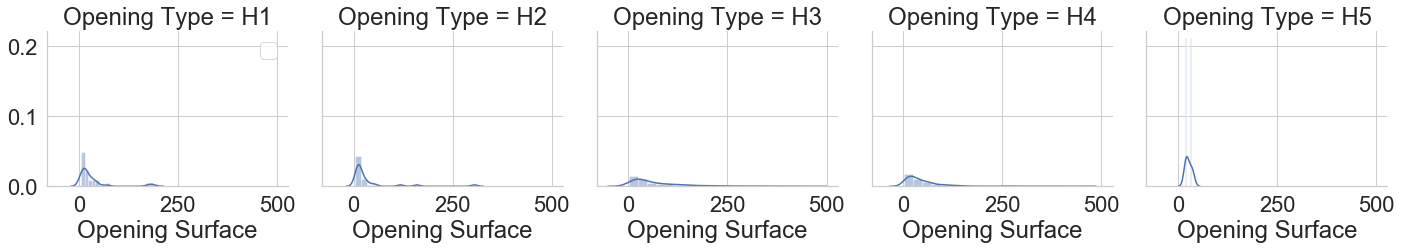

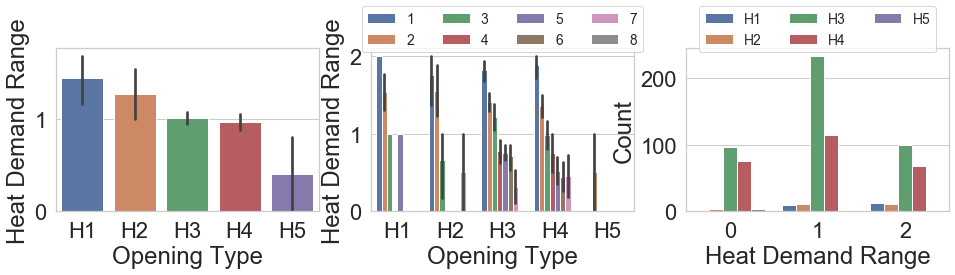

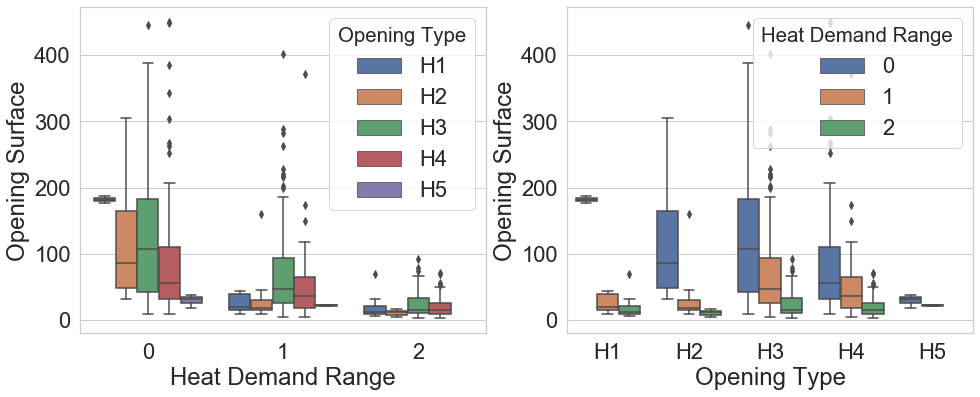

In [35]:
# Plot distributions by category
g=sns.FacetGrid(data_clean, col = 'Opening Type', 
            height = 4, aspect = 1, legend_out=False)
g=g.map(sns.distplot,'Opening Surface', bins = 20, kde=True).add_legend()

# Plot categorical and numerical variables
plt.figure(figsize = (16,3))
plt.subplot(1, 3, 1)
sns.barplot(x = 'Opening Type', y = 'Heat Demand Range', orient = 'v', 
            data = data_clean)

plt.subplot(1, 3, 2)
g = sns.barplot(x = "Opening Type", y = "Heat Demand Range", orient = 'v',
                hue = "Heights", data = data_clean)
plt.legend(loc='upper center', ncol = 4, fontsize = 'xx-small', 
           bbox_to_anchor = (0.5,1.3))

plt.subplot(1, 3, 3)
sns.countplot(x = 'Heat Demand Range',hue = 'Opening Type', orient = 'v',
              data = data_clean)
plt.ylabel("Count")
plt.legend(loc='upper center', ncol = 3, fontsize = 'xx-small', 
           bbox_to_anchor = (0.5,1.3))

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.boxplot(y = "Opening Surface", x = "Heat Demand Range", hue = "Opening Type",
                    data = data_clean)
plt.subplot(1,2,2)
sns.boxplot(y = 'Opening Surface' , x = 'Opening Type', hue = 'Heat Demand Range',
           data = data_clean)
plt.show()

The heat demand range is higher the lower the number of the opening classification. This is because the classification of openings is taking on a greater transmittance value, that is, a worse ability to retain heat or cold inside the house.

It says nothing beyond expected.

### Party Wall Type and Party Wall Surface

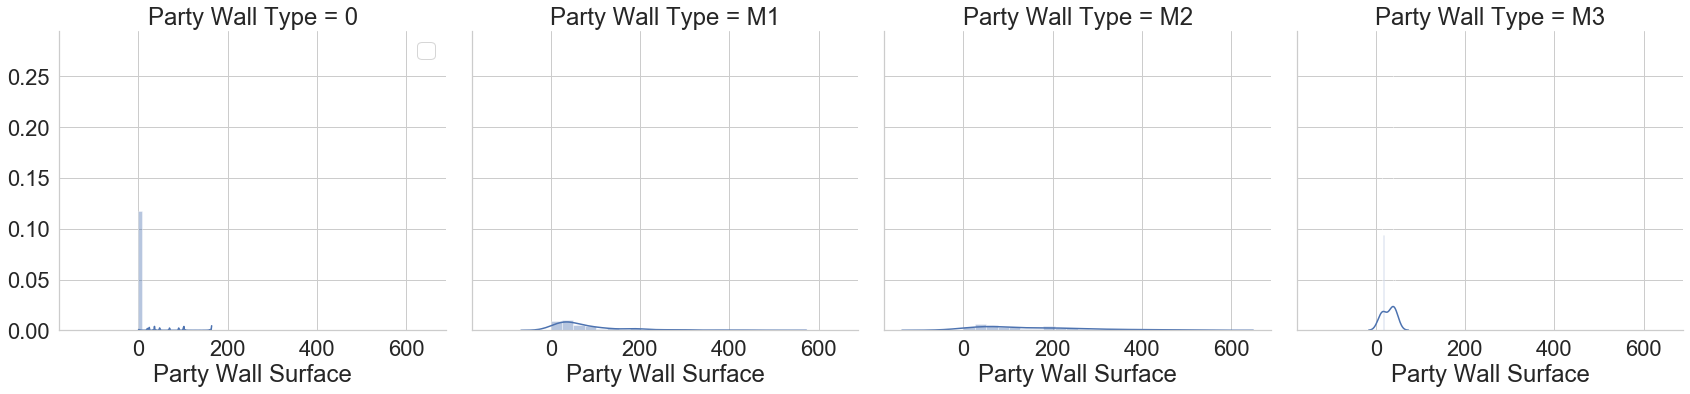

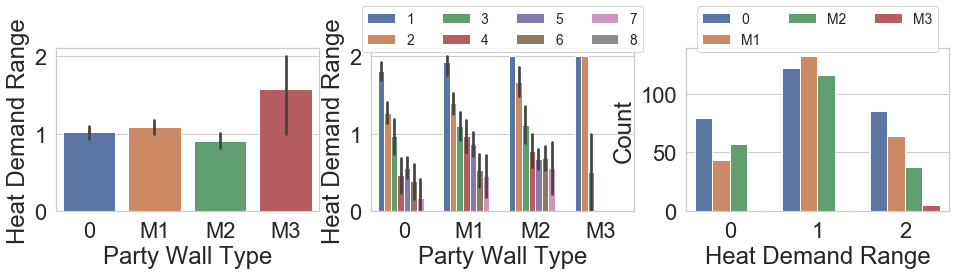

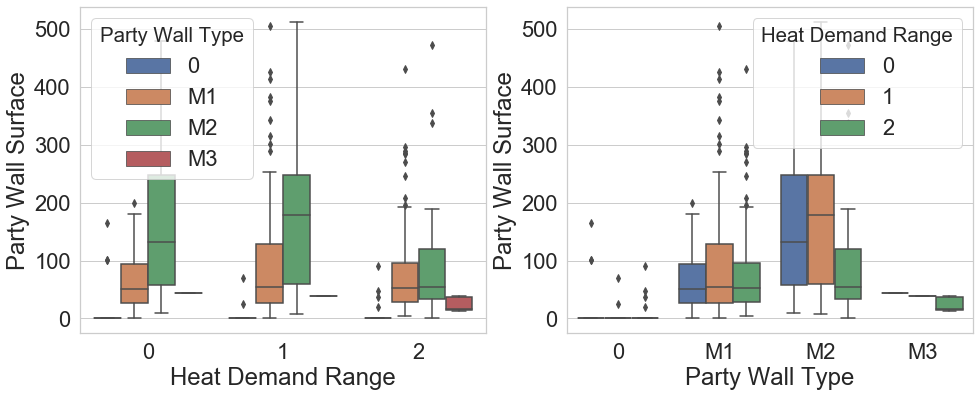

In [36]:
# Plot distributions by category
g=sns.FacetGrid(data_clean, col = 'Party Wall Type', 
            height = 6, aspect = 1, legend_out=False)
g=g.map(sns.distplot,'Party Wall Surface', bins = 20, kde=True).add_legend()

# Plot categorical and numerical variables
plt.figure(figsize = (16,3))
plt.subplot(1, 3, 1)
sns.barplot(x = 'Party Wall Type', y = 'Heat Demand Range', orient = 'v', 
            data = data_clean)

plt.subplot(1, 3, 2)
g = sns.barplot(x = "Party Wall Type", y = "Heat Demand Range", orient = 'v',
                hue = "Heights", data = data_clean)
plt.legend(loc='upper center', ncol = 4, fontsize = 'xx-small', 
           bbox_to_anchor = (0.5,1.3))

plt.subplot(1, 3, 3)
sns.countplot(x = 'Heat Demand Range',hue = 'Party Wall Type', orient = 'v',
              data = data_clean)
plt.ylabel("Count")
plt.legend(loc='upper center', ncol = 3, fontsize = 'xx-small', 
           bbox_to_anchor = (0.5,1.3))

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.boxplot(y = "Party Wall Surface", x = "Heat Demand Range", hue = "Party Wall Type",
                    data = data_clean)
plt.subplot(1,2,2)
sns.boxplot(y = 'Party Wall Surface' , x = 'Party Wall Type', hue = 'Heat Demand Range',
           data = data_clean)
plt.show()

Once again, we may be faced with poor data collection in cases where the surface of the medianera appears but not so its classification.

### Courtyard Surface and number of Courtyards

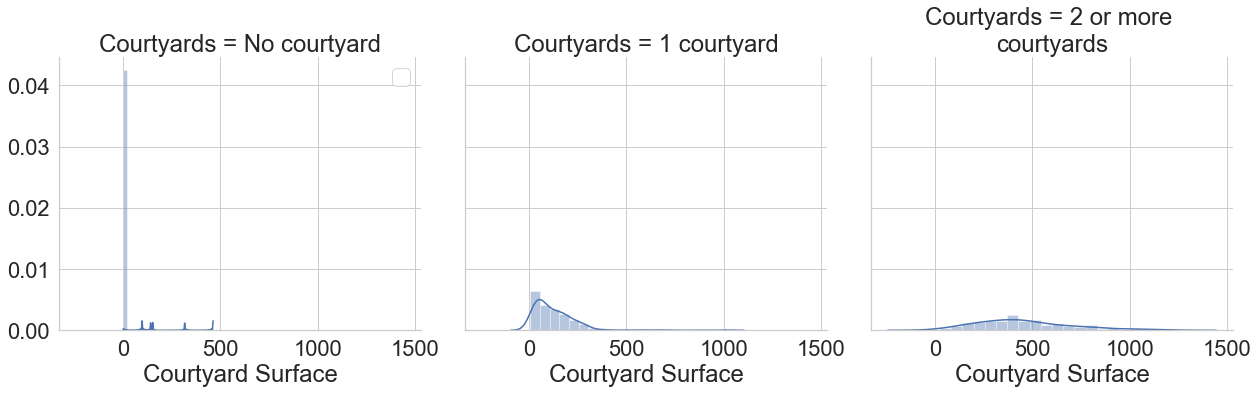

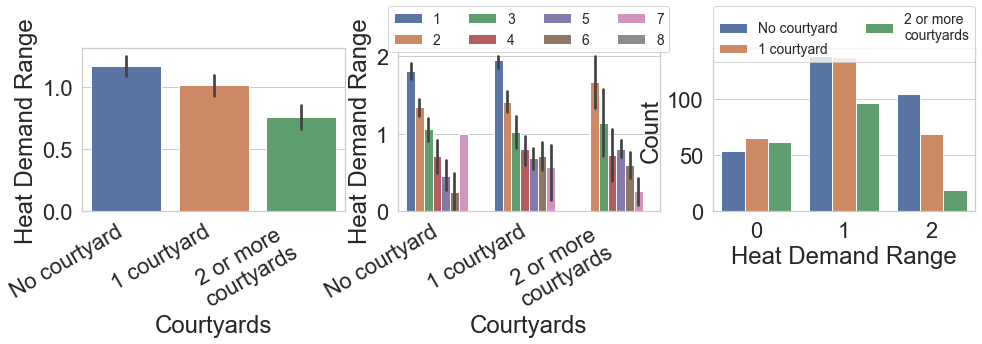

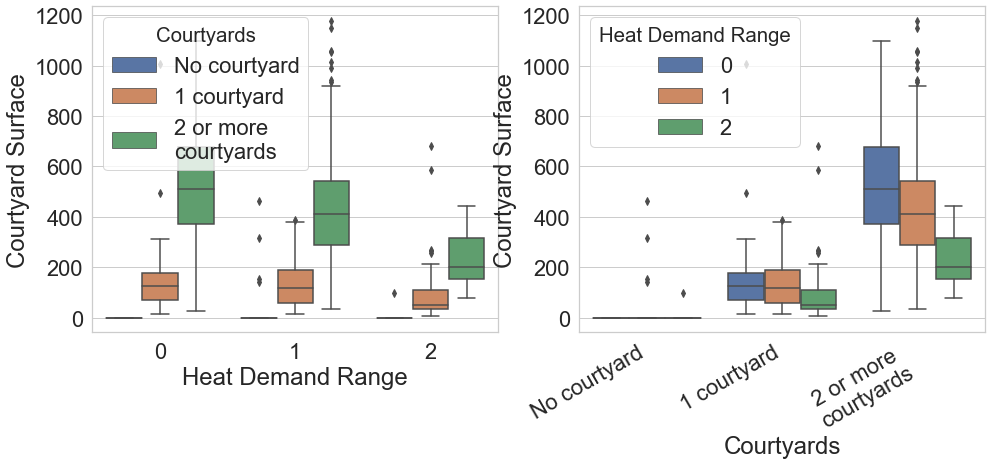

In [37]:
# Plot distributions by category
g=sns.FacetGrid(data_clean, col = 'Courtyards', 
            height = 6, aspect = 1, legend_out=False)
g=g.map(sns.distplot,'Courtyard Surface', bins = 20, kde=True).add_legend()

# Plot categorical and numerical variables
plt.figure(figsize = (16,3))
plt.subplot(1, 3, 1)
sns.barplot(x = 'Courtyards', y = 'Heat Demand Range', orient = 'v', 
            data = data_clean)
plt.xticks(rotation=30, ha = 'right')

plt.subplot(1, 3, 2)
g = sns.barplot(x = "Courtyards", y = "Heat Demand Range", orient = 'v',
                hue = "Heights", data = data_clean)
plt.legend(loc='upper center', ncol = 4, fontsize = 'xx-small', 
           bbox_to_anchor = (0.5,1.3))
plt.xticks(rotation=30, ha = 'right')

plt.subplot(1, 3, 3)
sns.countplot(x = 'Heat Demand Range',hue = 'Courtyards', orient = 'v',
              data = data_clean)
plt.ylabel("Count")
plt.legend(loc='upper center', ncol = 2, fontsize = 'xx-small', 
           bbox_to_anchor = (0.5,1.3))

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.boxplot(y = "Courtyard Surface", x = "Heat Demand Range", hue = "Courtyards",
                    data = data_clean)
plt.subplot(1,2,2)
sns.boxplot(y = 'Courtyard Surface' , x = 'Courtyards', hue = 'Heat Demand Range',
           data = data_clean)
plt.xticks(rotation=30, ha = 'right')
plt.show()

This can help us find more outliers in the data: buildings that do not have yards but have yard surfaces.

### Surface in Contact With Terrain

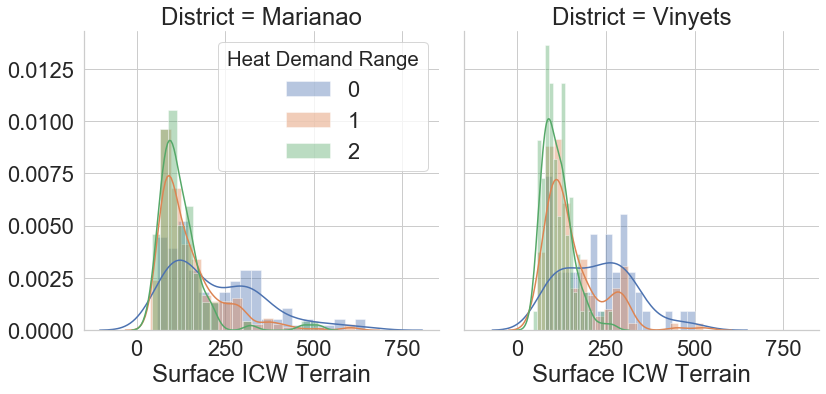

In [78]:
# Plot distributions by category
p1 = sns.FacetGrid(data_clean, col = 'District', hue = 'Heat Demand Range', 
            height = 6, aspect = 1, legend_out=False)
p1 = p1.map(sns.distplot,'Surface ICW Terrain', bins = 20, kde=True, label='Frequency').add_legend()
plt.show()

We can see in the distribution plots as the wider range of heating, the more concentrated the distribution of surface in contact with the ground in low values.

This again tells us that the size of the building will be one of the most determining factors in determining the range of heating demand.

### Conclusions

* The older and smaller the buildings, the greater the Heat Demand Range.
* The size of the building is the most determining variable. Qualitative variables condition the response of the building in terms of Heating Demand but none is significantly determinative of the rest.
* The strategy will have to be based on this information and produce the greatest reduction in demand, involving the smallest number of buildings and benefiting as many people as possible.
* Multivariable analysis was used to identify a greater number of data entry errors.